There are three total first one, finding Individuals and the Compounds they were treated with:

```
{"label":"Individual","query":[["mark","individual"],["to","drugTherapyFrom","Compound"],["mark","compound"],["select",["individual","compound"]]]}
```

Next one, using g2p associations to discover all drug targets for all genes:

```
{"label":"Compound","query":[["mark","compound"],["from","environmentFor","G2PAssociation"],["toUnique","genotypeOf","Gene"],["mark","gene"],["select",["gene","compound"]]]}
```
        
Finally, finding all Genes each Individual has a variant in:

```
{"label":"Individual","query":[["mark","individual"],["from","sampleOf","Biosample"],["from","callSetOf","CallSet",{"method":"MUTECT"}],["fromUnique","variantOf","Variant"],["toUnique","variantIn","Gene"],["mark","gene"],["select",["individual","gene"]]]}
```


Using these three sets of pairs, I was able to classify the treatments each individual received as either supported or unsupported by evidence
which gives us a few different cohorts to compare
I was planning on making Kaplan-Meier curves for the individuals who received treatments supported by g2p vs those whose treatments are unsupported by g2p evidence
The output of this process I delivered to Brian, it is living on swift at `biostream/source/individual-treatments.json`, if you want to see the results
Each entry in that file contains an Individual gid, their disease code, all genes they have variants in and three sets of compounds: supported, unsupported, and potential (those indicated by g2p associations but not applied as treatment to the individual)
Curious to compare the running time of these three queries with the ones you get from arachne, let me know how long they take you with our current dataset


In [33]:
# setup
!pip install attrdict

  Running setup.py bdist_wheel for attrdict ... done
  Stored in directory: /home/moc/.cache/pip/wheels/c3/a7/4e/ecbf6858a1940d22ecbe730445d8368c348e9b2735b959f6b7
Successfully built attrdict
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [310]:
# call bmeg
import requests
# better dict 
from attrdict import AttrDict

In [103]:
import datetime

class Timer(object):
    """A simple timer class"""
    
    def __init__(self):
        pass
    
    def start(self):
        """Starts the timer"""
        self.start = datetime.datetime.now()
        return self.start
    
    def stop(self, message="Total: "):
        """Stops the timer.  Returns the time elapsed"""
        self.stop = datetime.datetime.now()
        return message + str(self.stop - self.start)
    
    def now(self, message="Now: "):
        """Returns the current time with a message"""
        return message + ": " + str(datetime.datetime.now())
    
    def elapsed(self, message="Elapsed: "):
        """Time elapsed since start was called"""
        return message + str(datetime.datetime.now() - self.start)
    
    def split(self, message="Split started at: "):
        """Start a split timer"""
        self.split_start = datetime.datetime.now()
        return message + str(self.split_start)
    
    def unsplit(self, message="Unsplit: "):
        """Stops a split. Returns the time elapsed since split was called"""
        return message + str(datetime.datetime.now() - self.split_start)

In [125]:
class BMEG():    
    def __init__(self):
      base = "http://10.96.11.144"  
      self.url = base+"/query/{}"
      self.schema_url = "{}/schema/protograph".format(base)

    def query(self, label, q=[["where", {}], ["limit", 10]]):
        def decode(text):
            try:
                objs = []
                for l in text.splitlines():
                    d = AttrDict(json.loads(l))
                    objs.append(d)
                return objs
            except Exception as e:
                print text
                raise( Exception('exception: {}, text: {}'.format(e, text))) 

        url = self.url.format(label)    
        return decode(requests.post(url, json=q).text)

    def schema(self):
        return AttrDict(requests.get(self.schema_url, timeout=600).json())
    


In [105]:
# tests
assert  len(BMEG().query("ResponseCurve")) == 10, "default limit should be 10"
assert len(BMEG().schema().vertexes) == 26, "current vertexes is 26"
individual2Compound = AttrDict({"label":"Individual","query":[["mark","individual"],["to","drugTherapyFrom","Compound"],["mark","compound"],["select",["individual","compound"]]]})
individual2Compound.query += tuple([["limit",10]])
assert len(BMEG().query(individual2Compound.label, individual2Compound.query)) == 10, "custom query should limit at 10"

In [180]:
# get individuals and their therapies
timer = Timer()
timer.start()

individual2Compound = AttrDict({"label":"Individual","query":[["mark","individual"],["to","drugTherapyFrom","Compound"],["mark","compound"],["select",["individual","compound"]]]})
individual_compounds = BMEG().query(individual2Compound.label, individual2Compound.query)
# assert len(individual_compounds) == 2261
# assert individual_compounds[0].keys() == [u'individual', u'compound']
# print individual_compounds[0]
# AttrDict({u'individual': u'individual:a9d8a9e3-2a0d-4dbd-808f-646a624d2e0a', u'compound': u'compound:CID3690'})
print '{}, query: {}, len(results): {}'.format(timer.stop(), individual2Compound, len(individual_compounds))


Total: 0:00:02.009473, query: AttrDict({'query': [['mark', 'individual'], ['to', 'drugTherapyFrom', 'Compound'], ['mark', 'compound'], ['select', ['individual', 'compound']]], 'label': 'Individual'}), len(results): 2261


In [181]:
timer = Timer()
timer.start()
compound2Association = AttrDict({"label":"Compound","query":[["mark","compound"],["from","environmentFor","G2PAssociation"],["toUnique","genotypeOf","Gene"],["mark","gene"],["select",["gene","compound"]]]})
compound2Association.query
gene_compounds = BMEG().query(compound2Association.label, compound2Association.query)
# assert len(gene_compounds) == 24690
# assert gene_compounds[0].keys() == [u'gene', u'compound']
# print gene_compounds[0]
# AttrDict({u'gene': u'gene:ENSG00000108055', u'compound': u'compound:CID2756'})
print '{}, query: {}, len(results): {}'.format(timer.stop(), compound2Association, len(gene_compounds))


Total: 0:01:22.584137, query: AttrDict({'query': [['mark', 'compound'], ['from', 'environmentFor', 'G2PAssociation'], ['toUnique', 'genotypeOf', 'Gene'], ['mark', 'gene'], ['select', ['gene', 'compound']]], 'label': 'Compound'}), len(results): 24690


In [141]:
timer = Timer()
timer.start()

individualDiseaseCodes = AttrDict({"label":"Individual","query":
     [
         ["groupCount", "disease_code"]
     ]})


individual_disease_codes = BMEG().query(individualDiseaseCodes.label, individualDiseaseCodes.query)

print '{}, query: {}, len(results): {}'.format(timer.stop(), individualDiseaseCodes, len(individual_disease_codes))
disease_codes = [  dc.key for dc in individual_disease_codes]

Total: 0:00:00.061147, query: AttrDict({'query': [['groupCount', 'disease_code']], 'label': 'Individual'}), len(results): 25


In [145]:
timer = Timer()
timer.start()

disease_cohorts = []
# individual2Gene = AttrDict({"label":"Individual","query":[["mark","individual"],["from","sampleOf","Biosample"],["from","callSetOf","CallSet",{"method":"MUTECT"}],["fromUnique","variantCall","Variant"],["toUnique","variantIn","Gene"],["mark","gene"],["select",["individual","gene"]]]})
for disease_code in disease_codes:
    timer2 = Timer()
    timer2.start()    
    individual2Gene = AttrDict({"label":"Individual","query":
        [
         ["where",{"disease_code":disease_code}],             
         ["mark","individual"],
         ["from","sampleOf","Biosample"],
         ["from","callSetOf","CallSet"],
         ["where",{"method":"MUTECT"}],     
         ["fromUnique","variantCall","Variant"],
         ["toUnique","variantIn","Gene"],
         ["mark","gene"],
         ["select",["individual","gene"]]]})

    individual_genes = BMEG().query(individual2Gene.label, individual2Gene.query)
    print '{}, query: {}, len(results): {}'.format(timer2.stop(), individual2Gene, len(individual_genes))
    disease_cohorts.append({"disease_code":disease_code, 'individual_genes': individual_genes})

print '{}, len(disease_cohorts): {}'.format(timer.stop(), len(disease_cohorts))



Total: 0:00:00.970739, query: AttrDict({'query': [['where', {'disease_code': u'UVM'}], ['mark', 'individual'], ['from', 'sampleOf', 'Biosample'], ['from', 'callSetOf', 'CallSet'], ['where', {'method': 'MUTECT'}], ['fromUnique', 'variantCall', 'Variant'], ['toUnique', 'variantIn', 'Gene'], ['mark', 'gene'], ['select', ['individual', 'gene']]], 'label': 'Individual'}), len(results): 1699
Total: 0:00:00.135553, query: AttrDict({'query': [['where', {'disease_code': u'STAD'}], ['mark', 'individual'], ['from', 'sampleOf', 'Biosample'], ['from', 'callSetOf', 'CallSet'], ['where', {'method': 'MUTECT'}], ['fromUnique', 'variantCall', 'Variant'], ['toUnique', 'variantIn', 'Gene'], ['mark', 'gene'], ['select', ['individual', 'gene']]], 'label': 'Individual'}), len(results): 0
Total: 0:02:13.806024, query: AttrDict({'query': [['where', {'disease_code': u'SKCM'}], ['mark', 'individual'], ['from', 'sampleOf', 'Biosample'], ['from', 'callSetOf', 'CallSet'], ['where', {'method': 'MUTECT'}], ['fromUniq

Total: 0:00:01.468799, query: AttrDict({'query': [['where', {'disease_code': u'CHOL'}], ['mark', 'individual'], ['from', 'sampleOf', 'Biosample'], ['from', 'callSetOf', 'CallSet'], ['where', {'method': 'MUTECT'}], ['fromUnique', 'variantCall', 'Variant'], ['toUnique', 'variantIn', 'Gene'], ['mark', 'gene'], ['select', ['individual', 'gene']]], 'label': 'Individual'}), len(results): 3017
Total: 0:00:03.737077, query: AttrDict({'query': [['where', {'disease_code': u'THCA'}], ['mark', 'individual'], ['from', 'sampleOf', 'Biosample'], ['from', 'callSetOf', 'CallSet'], ['where', {'method': 'MUTECT'}], ['fromUnique', 'variantCall', 'Variant'], ['toUnique', 'variantIn', 'Gene'], ['mark', 'gene'], ['select', ['individual', 'gene']]], 'label': 'Individual'}), len(results): 7179
Total: 0:01:18.894183, query: AttrDict({'query': [['where', {'disease_code': u'LUAD'}], ['mark', 'individual'], ['from', 'sampleOf', 'Biosample'], ['from', 'callSetOf', 'CallSet'], ['where', {'method': 'MUTECT'}], ['from

In [316]:
assert len(disease_cohorts) == 25
assert len(individual_disease_codes) == len(disease_cohorts)

In [285]:
# individual_compounds : individuals and the compounds they have received
# gene_compounds : genes and the compounds attributed by g2p
# disease_cohorts: diseases and the individuals + compounds received

In [182]:
# xform from list of objs to hash indexed by individual
individual_compounds_hash = {}
for individual_compound in individual_compounds:
    if individual_compound.individual not in individual_compounds_hash:
        individual_compounds_hash[individual_compound.individual] = set([])
    individual_compounds_hash[individual_compound.individual].add(individual_compound.compound)
individual_compounds = individual_compounds_hash
individual_compounds_hash = None


# xform from list of objs to hash indexed by gene
gene_compounds_hash = {}
for gene_compound in gene_compounds:
    if gene_compound.gene not in gene_compounds_hash:
        gene_compounds_hash[gene_compound.gene] = set([])
    gene_compounds_hash[gene_compound.gene].add(gene_compound.compound)
gene_compounds = gene_compounds_hash
gene_compounds_hash = None


In [305]:
# create a hash of individuals, their disease & the treatment they received and the genes
individual_treatments = {}
for disease_cohort in disease_cohorts:
    for individual_gene in  disease_cohort['individual_genes']:
        # make sure the individual's key exists
        if individual_gene.individual not in individual_treatments:
            individual_treatments[individual_gene.individual] = {'gid': individual_gene.individual,
                                                                 'disease': disease_cohort['disease_code'],
                                                                 'supported': set([]),
                                                                 'unsupported': set([]),
                                                                 'potential': set([]),
                                                                 'variants': []
                                                                }
            individual_treatments[individual_gene.individual]['received'] = individual_compounds.get(individual_gene.individual, set([]))
        individual_treatments[individual_gene.individual]['variants'].append(individual_gene.gene)


In [306]:
# for individuals, determine evidence that exists and create sets supported, unsupported and potential treatments
for k in individual_treatments.keys():
    individual_treatment = individual_treatments[k]
    evidence = set([])
    for v in individual_treatment['variants']:
        evidence |= gene_compounds.get(v, set([]))
    individual_treatment['supported'] = individual_treatment['received'] & evidence
    individual_treatment['unsupported'] = individual_treatment['received'] - evidence
    individual_treatment['potential'] = evidence - individual_treatment['received']
        

In [307]:
# test
for idx,k in enumerate(individual_treatments):
    individual_treatment = AttrDict(individual_treatments[k])
    # validate all potential treatments are actually linked by gene
    evidence = set([])
    for v in individual_treatment.variants:
        evidence |= gene_compounds.get(v, set([]))
    for p in individual_treatment.potential:
        assert p in evidence, 'potential should be in evidence'
    for u in individual_treatment.unsupported:
        assert u not in evidence, 'unsupported should not be in evidence'        


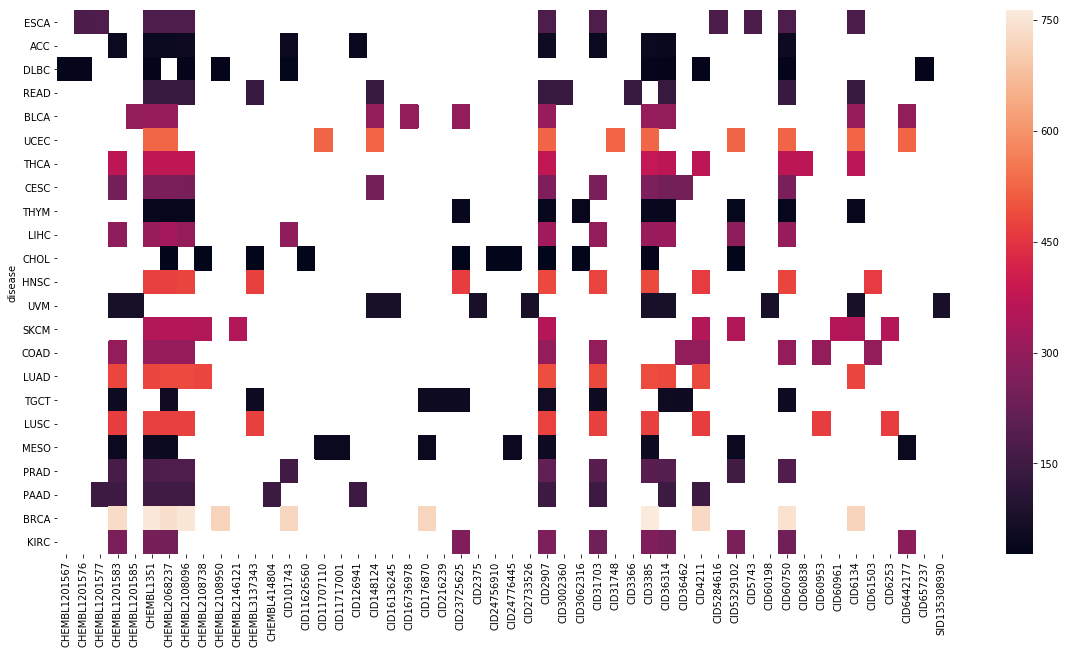

In [311]:
import json
from pprint import pprint
import pandas as pd
import operator
import seaborn as sns
import matplotlib

# for potential compounds, lets summarize by individual.disease
disease_potential_treatments = {}
for c,k in enumerate(individual_treatments):
    individual_treatment = individual_treatments[k]
    potentials = individual_treatment.get('potential',None) or []
    if individual_treatment['disease'] not in disease_potential_treatments:
        disease_potential_treatments[individual_treatment['disease']] = {}
    disease = disease_potential_treatments[individual_treatment['disease']]   
    for potential_compound in potentials:
        if potential_compound not in disease:
           disease[potential_compound] = 0
        disease[potential_compound] += 1     
        

# sort an dict of flattened objects, keyed by disease , each with top 10
def top_N(mydict, target, limit=10):
    sorted_mydict = sorted(mydict.items(), key=operator.itemgetter(1), reverse=True)        
    for c,t in enumerate(sorted_mydict):
        if c > limit:
            break
        # strip off 'compound:' for chart    
        target[t[0].replace('compound:','')] = t[1]   

disease_top_potential_treatments = []        
for k in disease_potential_treatments:
    d = {'disease': k}
    top_N(disease_potential_treatments[k],d)
    disease_top_potential_treatments.append(d)


# load it into panda to plot    
df = pd.DataFrame(data=disease_top_potential_treatments)
df = df.set_index('disease')

%matplotlib inline
matplotlib.rcParams['figure.figsize']  = [20,10]
sns.heatmap(df, cbar=True)



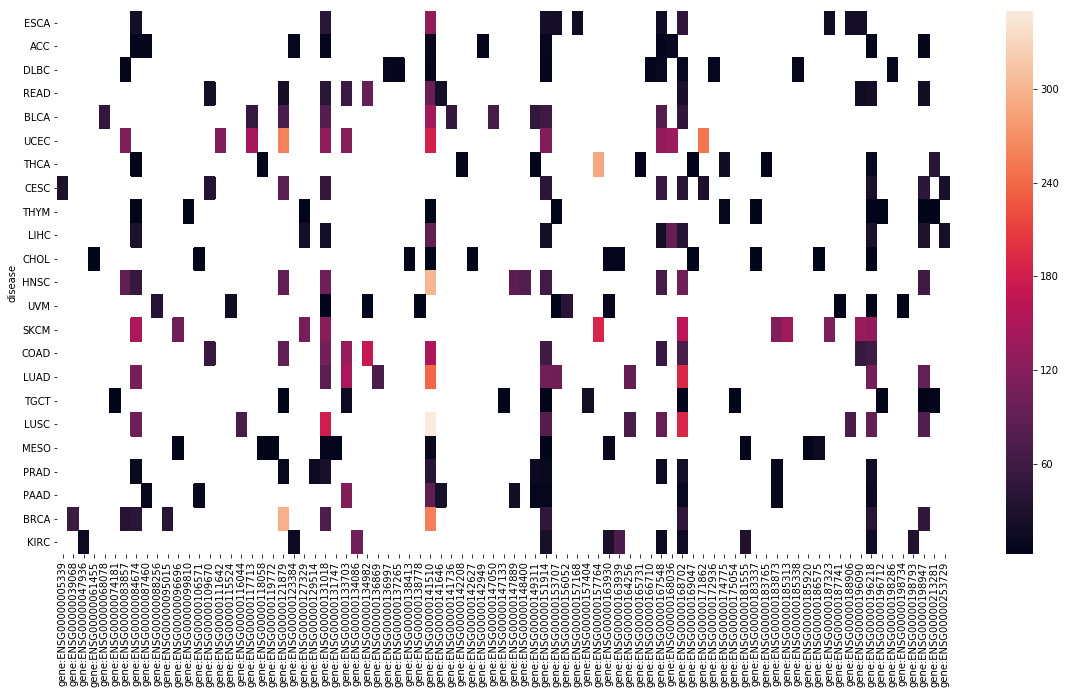

In [315]:
import json
from pprint import pprint
import pandas as pd
import operator
import seaborn as sns
import matplotlib

# for potential compounds, lets summarize by individual.disease
disease_genes_with_evidence = {}
for c,k in enumerate(individual_treatments):
    individual_treatment = individual_treatments[k]
    variants = individual_treatment.get('variants',None) or []
    evidence = set([])
    for v in variants:
        if gene_compounds.get(v, None):
            evidence.add(v)
    if individual_treatment['disease'] not in disease_genes_with_evidence:
        disease_genes_with_evidence[individual_treatment['disease']] = {}
    disease = disease_genes_with_evidence[individual_treatment['disease']]   
    for e in evidence:
        if e not in disease:
           disease[e] = 0
        disease[e] += 1     
        

# sort an dict of flattened objects, keyed by disease , each with top 10
def top_N(mydict, target, limit=10):
    sorted_mydict = sorted(mydict.items(), key=operator.itemgetter(1), reverse=True)        
    for c,t in enumerate(sorted_mydict):
        if c > limit:
            break
        # strip off 'compound:' for chart    
        target[t[0].replace('compound:','')] = t[1]   

disease_top_potential_genes = []        
for k in disease_genes_with_evidence:
    d = {'disease': k}
    top_N(disease_genes_with_evidence[k],d)
    disease_top_potential_genes.append(d)


# load it into panda to plot    
df = pd.DataFrame(data=disease_top_potential_genes)
df = df.set_index('disease')

%matplotlib inline
matplotlib.rcParams['figure.figsize']  = [20,10]
sns.heatmap(df, cbar=True)

